In [1]:
#import numpy as np
import matplotlib.pyplot as plt
#import pyedflib
import wfdb
import glob
import random
import gc
import mne
from scipy.signal import find_peaks
import re
import tqdm
import logging
import os
import numpy as np

In [2]:
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
             'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
             'FZ-CZ', 'CZ-PZ']

In [3]:
path2pt = '/mnt/speech6/bagher/nemati/pytorch_datasets/chb_mit_raw'

folders = sorted(glob.glob(path2pt+'/*/'))
n_patient = [m[-2:] for m in [l.rsplit('/', 2)[-2] for l in folders]]

print(*n_patient)

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


In [4]:
random.seed(2023)

ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patient, round(ratio_train*len(n_patient))))
test_patient_str = sorted([l for l in n_patient if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)

Train PT:  02 03 04 05 06 09 11 12 13 14 15 16 17 18 19 20 21 23 24
Test PT:  01 07 08 10 22


In [5]:
files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

In [6]:
len(files_train), len(files_test)

(549, 137)

In [7]:
mne.set_log_level(verbose='ERROR')

In [ ]:
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

time_window = 8
time_step = 4

root = "/mnt/speech6/bagher/nemati/pytorch_datasets"

if os.path.exists(f'{root}/signal_samples.npy')&os.path.exists(f'{root}/is_sz.npy'):
    array_signals=np.load(f'{root}/signal_samples.npy')
    array_is_sz=np.load(f'{root}/is_sz.npy')
else:
    p = 0.01  
    counter = 0
    for temp_f in files_train:
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs # 8*256
            step = time_step*fs # 4*256
            
            temp_is_sz = np.zeros((temp_edf.n_times,))
            if os.path.exists(temp_f+'.seizures'):
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            temp_len = temp_edf.n_times # 100000*256
            
            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            counter = counter + temp_0_sample_size + temp_1_sample_size
        temp_edf.close()

    array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
    array_is_sz = np.zeros(counter, dtype=bool)

    counter = 0
    for n, temp_f in enumerate(tqdm.tqdm(files_train)):
        to_log = 'No. {}: Reading. '.format(n)
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        n_label_match = sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])
        if n_label_match==len(ch_labels):
            ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
            temp_edf.rename_channels(ch_mapping)
            #temp_edf = temp_edf.pick(ch_labels)

            temp_is_sz = np.zeros((temp_edf.n_times,))
            temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

            if os.path.exists(temp_f+'.seizures'):
                to_log = to_log+'sz exists.'
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            else:
                to_log = to_log+'No sz.'

            temp_len = temp_edf.n_times

            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs

            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )
            del temp_is_sz

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            # sz data
            temp_ind = list(np.where(temp_is_sz_ind>0)[0])
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = True
                counter = counter+1

            # no sz data
            temp_ind = random.sample(list(np.where(temp_is_sz_ind==0)[0]), temp_0_sample_size)
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = False
                counter = counter+1

            to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(
                temp_0_sample_size+temp_1_sample_size, temp_0_sample_size, temp_1_sample_size
            )

        else:
            to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)
        
        logger.info(to_log)
        temp_edf.close()

        if n%10==0:
            gc.collect()
    gc.collect()
    
    np.save('signal_samples', array_signals)
    np.save('is_sz', array_is_sz)

In [13]:
array_signals = np.load('signal_samples.npy')
array_is_sz = np.load('is_sz.npy')

In [4]:
array_signals.shape

(36859, 18, 256)

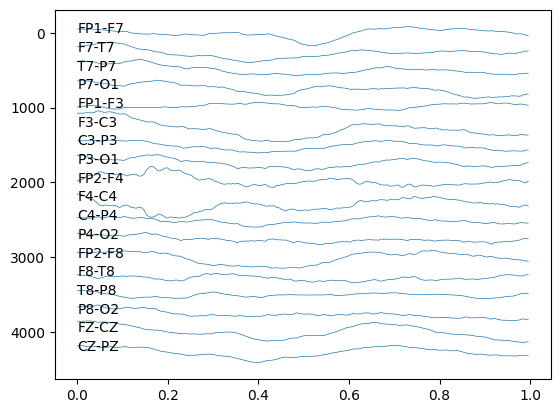

In [14]:
# show a sample of extracted signals (the last one)

vertical_width = 250
signals = array_signals[-1, :, :]
fs = 256

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()


In [15]:
# Checking how much of signals have seizure inside.

array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))

Number of all the extracted signals: 36859
Number of signals with seizures: 9188
Ratio of signals with seizures: 0.249


In [16]:
from sklearn import model_selection

# CNN will be used. Channel dimension is added.
array_signals = array_signals[:, :, :, np.newaxis]

print(array_signals.shape)

# splitting training data into training & validation data.

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    array_signals, array_is_sz, test_size=0.3,
    stratify=(array_is_sz>0))

del array_signals, array_is_sz

print(X_train.shape)

(36859, 18, 256, 1)
(25801, 18, 256, 1)


In [9]:
import torch as pt

root = "/mnt/speech6/bagher/nemati/pytorch_datasets/chb_mit_window_1"
items = glob.glob(f"{root}/**/*.pt", recursive=True)

train_items = list(filter(lambda item: any([f"chb{p}" in item for p in train_patient_str]), items))
test_items = list(filter(lambda item: any([f"chb{p}" in item for p in test_patient_str]), items))

X_train = []
y_train = []
X_test = []
y_test = []

for item in train_items:
    record = pt.load(item)
    data = np.zeros((23, record["data"].shape[1]), dtype=np.float32)
    data[:record["data"].shape[0]] = record["data"]

    X_train.append(data * 1e6)
    y_train.append(record["labels"].max())

for item in test_items:
    record = pt.load(item)
    data = np.zeros((23, record["data"].shape[1]), dtype=np.float32)
    data[:record["data"].shape[0]] = record["data"]

    X_test.append(data * 1e6)
    y_test.append(record["labels"].max())

X_train = np.stack(X_train)
y_train = np.array(y_train)
X_test = np.stack(X_test)
y_test = np.array(y_test)

X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

In [10]:
X_val = X_test
y_val = y_test

In [11]:
X_val.shape

(11685, 1, 23, 256)

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = keras.models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(1, 4), data_format="channels_first", activation='relu', input_shape=X_train.shape[1:]),
    layers.Conv2D(filters=64, kernel_size=(1, 4), data_format="channels_first", activation='relu'),
    layers.MaxPooling2D((2, 1)),

    layers.Conv2D(filters=128, kernel_size=(1, 8), data_format="channels_first", activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(1, 8), data_format="channels_first", activation='relu'),
    layers.MaxPooling2D((2, 1)),
    
    layers.Conv2D(filters=256, kernel_size=(1, 16), data_format="channels_first", activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(1, 16), data_format="channels_first", activation='relu'),
    layers.MaxPooling2D((2, 1)),

    layers.Conv2D(filters=1, kernel_size=(1, 1), data_format="channels_first", padding='same', activation='relu'),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(2, activation='softmax'),
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 64, 23, 256)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 64, 23, 128)    │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 128, 23, 128)   │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 23, 64)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 256, 23, 64)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 256, 23, 32)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 128, 23, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 1, 23, 32)      │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,995 (1.82 MB)

 Trainable params: 476,995 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val + 0),
    epochs=200,
    batch_size=256,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)
    ]
)

Epoch 1/200


I0000 00:00:1719907004.233245 2506379 service.cc:145] XLA service 0x722bc8006290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719907004.233293 2506379 service.cc:153]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
I0000 00:00:1719907004.233299 2506379 service.cc:153]   StreamExecutor device (1): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-07-02 00:56:44.357471: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-02 00:56:44.807853: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2024-07-02 00:56:50.226936: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,256,23,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,256,23,32]{3,2,1,0}, f32[256,256,1,4]{3,2,1,0}), window={size=1x4 stride=1x2 pad=0_0x1_1}, 

  2/140 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.4824 - loss: 0.6932 

I0000 00:00:1719907017.944047 2506379 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 192ms/step - accuracy: 0.7833 - loss: 0.6707 - val_accuracy: 0.8000 - val_loss: 0.5474
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.8006 - loss: 0.5222 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.7968 - loss: 0.5087 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 4/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.7990 - loss: 0.5046 - val_accuracy: 0.8000 - val_loss: 0.5005
Epoch 5/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.7979 - loss: 0.5075 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 6/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.7975 - loss: 0.5079 - val_accuracy: 0.8000 - val_loss: 0.5005
Epoch 7/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.8036 - loss: 0.4992 - val_accuracy: 0.8000 - val_loss: 0.5005
Epoch 8/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.8003 - loss: 0.5028 - val

: 

In [10]:
import numpy as np
import torch as pt
import torch.nn as T
import lightning as L
import torchmetrics as M

from torch.utils.data import DataLoader

class EEGCNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters({})
        self.loss = pt.nn.CrossEntropyLoss()

        self.metrics = M.MetricCollection({
            # "f1": M.F1Score(task="multiclass", num_classes=num_classes),
            # "recall": M.Recall(task="multiclass", num_classes=num_classes),
            "accuracy": M.Accuracy(task="multiclass", num_classes=2),
            # "precision": M.Precision(task="multiclass", num_classes=num_classes),
        })

        self.training_metrics = self.metrics.clone(prefix="training/")
        self.validation_metrics = self.metrics.clone(prefix="validation/")

        self.model = T.Sequential(
            T.Conv2d(in_channels=1, out_channels=64, kernel_size=(2, 4), padding='same'),
            T.ReLU(),
            T.Conv2d(in_channels=64, out_channels=64, kernel_size=(2, 4), stride=(1, 2)),
            T.ReLU(),
            T.MaxPool2d((1, 2)),

            T.Conv2d(in_channels=64, out_channels=128, kernel_size=(2, 4), padding='same'),
            T.ReLU(),
            T.Conv2d(in_channels=128, out_channels=128, kernel_size=(2, 4), stride=(1, 2)),
            T.ReLU(),
            T.MaxPool2d((2, 2)),

            T.Conv2d(in_channels=128, out_channels=256, kernel_size=(4, 4), padding='same'),
            T.ReLU(),
            T.Conv2d(in_channels=256, out_channels=256, kernel_size=(4, 4), stride=(1, 2)),
            T.ReLU(),
            T.MaxPool2d((1, 2)),

            T.AdaptiveAvgPool2d((1, 1)),
            T.Flatten(),

            T.Linear(256, 256),
            T.ReLU(),
            T.Dropout(0.25),
            T.Linear(256, 128),
            T.ReLU(),
            T.Linear(128, 64),
            T.ReLU(),
            T.Dropout(0.25),
            T.Linear(64, 2),
            # T.Softmax(dim=-1),
        )
        def init_weights(m):
            if isinstance(m, T.Linear):
                T.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
        
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = pt.optim.Adam(self.model.parameters(), lr=1e-4)
        # scheduler = pt.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        return [optimizer]

    def on_train_start(self):
        self.logger.log_hyperparams(self.hparams, {
            "training/f1": 0,
            "training/recall": 0,
            "training/accuracy": 0,
            "training/precision": 0,
        })

    def general_step(self, batch):
        batch_size = len(batch[1])
        args = (batch[0],)
        y = batch[1]

        pred = self.forward(*args)
        loss = self.loss(pred, y)
        pred = pred.argmax(-1)

        return (batch_size, args, loss, pred, y)

    def training_step(self, batch):
        batch_size, _, loss, pred, y = self.general_step(batch)

        self.log("training/loss", loss, batch_size=batch_size, prog_bar=True, sync_dist=True)
        self.log_dict(self.training_metrics(pred, y), batch_size=batch_size, prog_bar=True, sync_dist=True)

        return loss

    def validation_step(self, batch):
        batch_size, _, loss, pred, y = self.general_step(batch)

        self.log("validation/loss", loss, batch_size=batch_size, prog_bar=True, sync_dist=True)
        self.log_dict(self.validation_metrics(pred, y), batch_size=batch_size, prog_bar=True, sync_dist=True)

In [12]:
import lightning as L

class DataSet:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return (self.X[index], self.y[index] + 0)

trainer = L.Trainer(max_epochs=50)
trainer.fit(
    model=EEGCNN(),
    train_dataloaders=DataLoader(dataset=DataSet(X=X_train, y=y_train), batch_size=256, shuffle=True),
    val_dataloaders=DataLoader(dataset=DataSet(X=X_val, y=y_val), batch_size=256)
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type             | Params
--------------------------------------------------------
0 | loss               | CrossEntropyLoss | 0     
1 | metrics            | MetricCollection | 0     
2 | training_metrics   | MetricCollection | 0     
3 | validation_metrics | MetricCollection | 0     
4 | model              | Sequential       | 1.9 M 
--------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.643     Total estima

Epoch 24:  54%|█████▎    | 75/140 [00:14<00:12,  5.21it/s, v_num=1, training/loss=0.035, training/accuracy=0.992, validation/loss=0.928, validation/accuracy=0.888]   

/mnt/speech6/bagher/nemati/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
